<a href="https://colab.research.google.com/github/mandar4415/ECG-Arrhythmia-Detection-with-Neural-Networks/blob/main/Cvproc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install wfdb PyWavelets imbalanced-learn matplotlib tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.0 MB/s eta 0:00:00


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  # For reading MIT-BIH dataset
import pywt  # For wavelet transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [13]:
# Download MIT-BIH Arrhythmia Database
!wget -q https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip -q mit-bih-arrhythmia-database-1.0.0.zip
!rm mit-bih-arrhythmia-database-1.0.0.zip

# Define the path to the dataset
data_path = 'mit-bih-arrhythmia-database-1.0.0/'

# List all record names
records = [f[:-4] for f in os.listdir(data_path) if f.endswith('.dat')]

# AAMI recommended classes mapping
aami_classes = {
    'N': ['N', 'L', 'R', 'e', 'j'],  # Normal and bundle branch blocks
    'S': ['A', 'a', 'J', 'S'],       # Supraventricular
    'V': ['V', 'E'],                  # Ventricular
    'F': ['F'],                       # Fusion
    'Q': ['/', 'f', 'Q']              # Unknown/Quotable
}

# More detailed class mapping (you can adjust this based on your needs)
detailed_classes = {
    'N': 'Normal',
    'L': 'Left Bundle Branch Block',
    'R': 'Right Bundle Branch Block',
    'A': 'Atrial Premature',
    'a': 'Aberrated Atrial Premature',
    'J': 'Nodal (Junctional) Premature',
    'S': 'Supraventricular Premature',
    'V': 'Premature Ventricular Contraction',
    'F': 'Fusion of Ventricular and Normal',
    'e': 'Atrial Escape',
    'j': 'Nodal (Junctional) Escape',
    'E': 'Ventricular Escape',
    '/': 'Paced',
    'f': 'Fusion of Paced and Normal',
    'Q': 'Unclassifiable'
}

def load_annotations(record):
    """Load annotations for a record and return beats with their labels."""
    annotation = wfdb.rdann(os.path.join(data_path, record), 'atr')
    samples = annotation.sample
    symbols = annotation.symbol

    # Get the ECG signal (using MLII lead as it's commonly available)
    signals, fields = wfdb.rdsamp(os.path.join(data_path, record))
    ecg = signals[:, 0]  # Using first lead

    beats = []
    labels = []

    # Extract beats around R-peaks (annotations)
    for i, (sample, symbol) in enumerate(zip(samples, symbols)):
        if symbol in detailed_classes:
            # Extract 280ms window around the R-peak (100 samples before and 180 after)
            start = max(0, sample - 100)
            end = min(len(ecg), sample + 180)

            beat = ecg[start:end]

            # Pad if necessary
            if len(beat) < 280:
                beat = np.pad(beat, (0, 280 - len(beat)), 'constant')

            beats.append(beat)
            labels.append(symbol)

    return np.array(beats), np.array(labels)

# Load all records
all_beats = []
all_labels = []

for record in records[:10]:  # Using first 10 records for demo (remove limit for full dataset)
    try:
        beats, labels = load_annotations(record)
        all_beats.extend(beats)
        all_labels.extend(labels)
    except:
        continue

all_beats = np.array(all_beats)
all_labels = np.array(all_labels)

# Filter only classes we're interested in
selected_classes = ['N', 'L', 'R', 'A', 'V', 'F', '/']
mask = np.isin(all_labels, selected_classes)
filtered_beats = all_beats[mask]
filtered_labels = all_labels[mask]

# Convert labels to numerical values
label_to_num = {label: i for i, label in enumerate(selected_classes)}
y = np.array([label_to_num[label] for label in filtered_labels])
X = filtered_beats

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train_res = X_train_res.reshape(-1, X_train.shape[1], 1)

# One-hot encode labels
y_train_res_encoded = to_categorical(y_train_res, num_classes=len(selected_classes))
y_test_encoded = to_categorical(y_test, num_classes=len(selected_classes))

# Normalize the data
def normalize(beat):
    beat = beat - np.mean(beat)
    beat = beat / np.std(beat)
    return beat

X_train_res = np.array([normalize(beat) for beat in X_train_res])
X_test = np.array([normalize(beat) for beat in X_test])

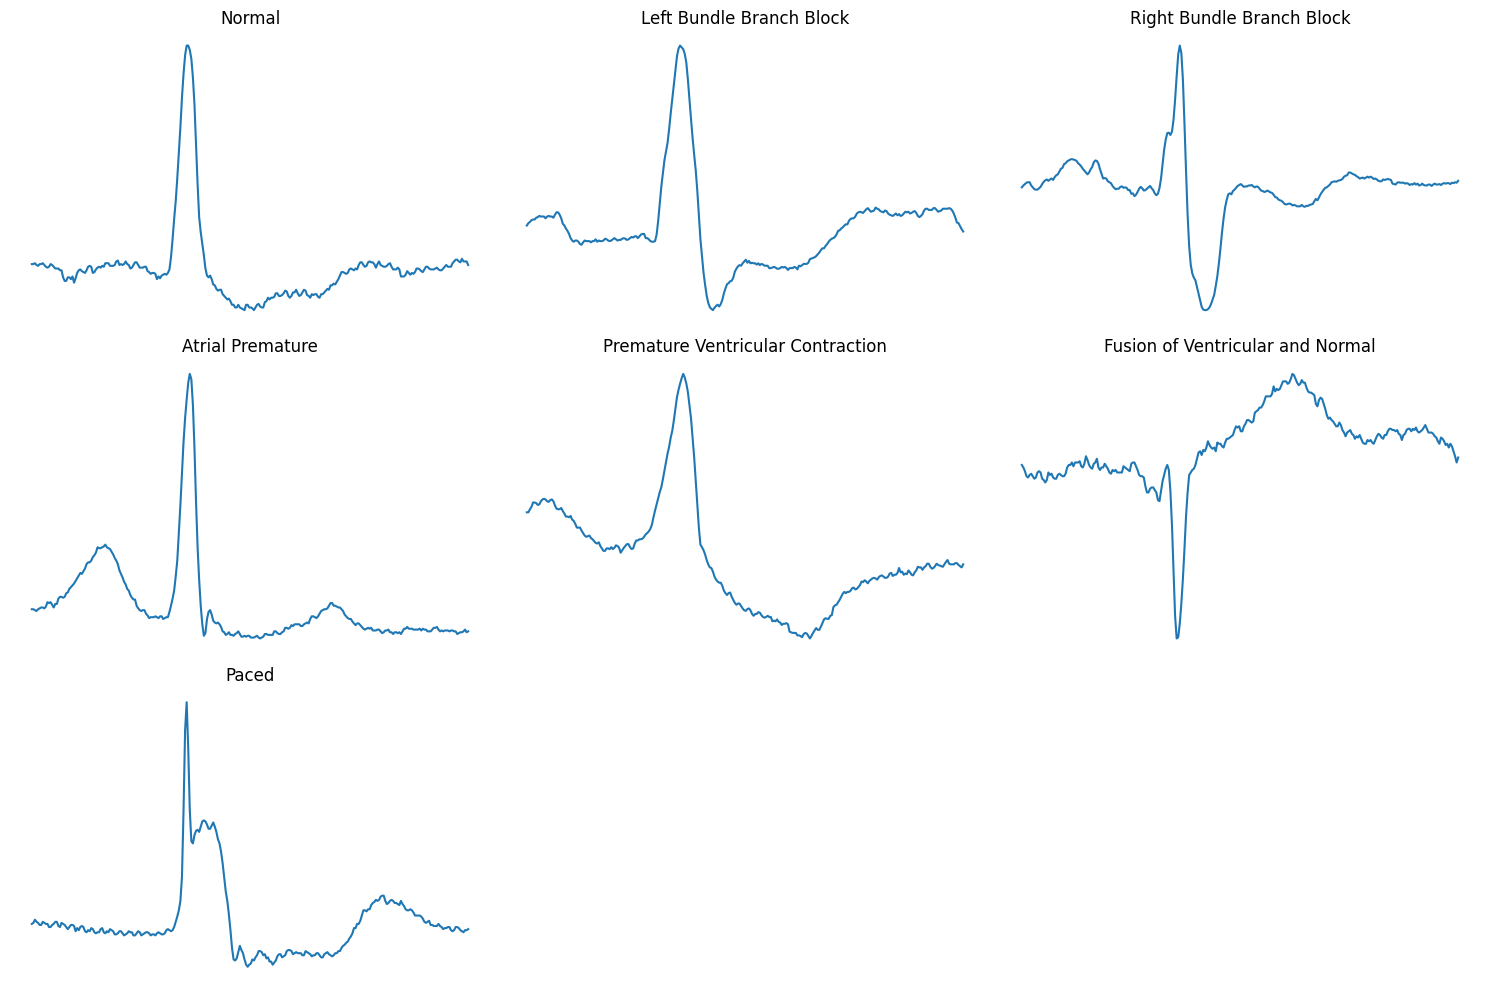

In [14]:
# Data augmentation
def augment_beat(beat):
    # Random scaling
    scale = np.random.uniform(0.8, 1.2)
    beat = beat * scale

    # Random time warping
    if np.random.rand() > 0.5:
        original_length = beat.shape[0]
        new_length = int(original_length * np.random.uniform(0.9, 1.1))
        beat = np.interp(
            np.linspace(0, original_length-1, new_length),
            np.arange(original_length),
            beat.squeeze()
        ).reshape(-1, 1)
        # Pad or crop to maintain original length
        if new_length < original_length:
            beat = np.pad(beat, ((0, original_length - new_length), (0, 0)), 'constant')
        else:
            beat = beat[:original_length]

    # Add random noise
    noise = np.random.normal(0, 0.05, beat.shape)
    beat = beat + noise

    return beat

# Visualize some samples
plt.figure(figsize=(15, 10))
for i, label in enumerate(selected_classes):
    idx = np.where(y_train_res == i)[0][0]
    plt.subplot(3, 3, i+1)
    plt.plot(X_train_res[idx])
    plt.title(detailed_classes[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
def create_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional blocks
    model.add(layers.Conv1D(64, 15, activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(128, 11, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(256, 7, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(512, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    # Attention mechanism
    attention = layers.Conv1D(1, 1, activation='tanh')(model.layers[-2].output)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(512)(attention)
    attention = layers.Permute([2, 1])(attention)

    # Apply attention
    multiplied = layers.Multiply()([model.layers[-2].output, attention])

    # Continue with the model
    x = layers.GlobalAveragePooling1D()(multiplied)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=model.inputs, outputs=outputs)

    return model

# Create model
input_shape = (X_train_res.shape[1], X_train_res.shape[2])
model = create_model(input_shape, len(selected_classes))

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 280, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 280, 64)   │      1,024 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 280, 64)   │        256 │ conv1d[10][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 140, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 140, 128)  │     90,240 │ max_pooling1d[8]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 128)  │        512 │ conv1d_1[7][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 70, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 70, 256)   │    229,632 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 70, 256)   │      1,024 │ conv1d_2[4][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 35, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 35, 512)   │    393,728 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 512)   │      2,048 │ conv1d_3[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 35, 1)     │        513 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 35)        │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 35)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 512, 35)   │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 35, 512)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 35, 512)   │          0 │ batch_normalizat… │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 884,104 (3.37 MB)

 Trainable params: 882,184 (3.37 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 280, 1))
  warnings.warn(msg)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8790 - auc: 0.9806 - loss: 0.3994 - precision: 0.9203 - recall: 0.8031

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 527s 516ms/step - accuracy: 0.8790 - auc: 0.9806 - loss: 0.3992 - precision: 0.9203 - recall: 0.8032 - val_accuracy: 0.9933 - val_auc: 1.0000 - val_loss: 0.0165 - val_precision: 0.9933 - val_recall: 0.9932 - learning_rate: 0.0010
Epoch 2/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9845 - auc: 0.9993 - loss: 0.0498 - precision: 0.9852 - recall: 0.9837

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 550s 504ms/step - accuracy: 0.9845 - auc: 0.9993 - loss: 0.0498 - precision: 0.9852 - recall: 0.9837 - val_accuracy: 0.9980 - val_auc: 0.9999 - val_loss: 0.0048 - val_precision: 0.9980 - val_recall: 0.9980 - learning_rate: 0.0010
Epoch 3/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9901 - auc: 0.9997 - loss: 0.0305 - precision: 0.9905 - recall: 0.9897

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 512s 507ms/step - accuracy: 0.9901 - auc: 0.9997 - loss: 0.0305 - precision: 0.9905 - recall: 0.9897 - val_accuracy: 0.9998 - val_auc: 1.0000 - val_loss: 4.2964e-04 - val_precision: 0.9998 - val_recall: 0.9998 - learning_rate: 0.0010
Epoch 4/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 510s 505ms/step - accuracy: 0.9935 - auc: 0.9997 - loss: 0.0208 - precision: 0.9937 - recall: 0.9932 - val_accuracy: 0.9993 - val_auc: 0.9998 - val_loss: 0.0045 - val_precision: 0.9996 - val_recall: 0.9993 - learning_rate: 0.0010
Epoch 5/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 576s 519ms/step - accuracy: 0.9954 - auc: 0.9998 - loss: 0.0153 - precision: 0.9954 - recall: 0.9952 - val_accuracy: 0.9176 - val_auc: 0.9849 - val_loss: 0.3453 - val_precision: 0.9183 - val_recall: 0.9162 - learning_rate: 0.0010
Epoch 6/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 560s 518ms/step - accuracy: 0.9956 - auc: 0.9998 - loss: 0.0147 - precision: 0.9957 - recall: 0.9954 - val_accuracy: 0.9997 - val_auc: 1.0000 - va

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 521s 516ms/step - accuracy: 0.9958 - auc: 0.9998 - loss: 0.0132 - precision: 0.9958 - recall: 0.9958 - val_accuracy: 0.9999 - val_auc: 1.0000 - val_loss: 2.5015e-04 - val_precision: 0.9999 - val_recall: 0.9999 - learning_rate: 0.0010
Epoch 9/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 562s 517ms/step - accuracy: 0.9976 - auc: 0.9998 - loss: 0.0083 - precision: 0.9976 - recall: 0.9974 - val_accuracy: 0.9997 - val_auc: 0.9999 - val_loss: 0.0017 - val_precision: 0.9998 - val_recall: 0.9997 - learning_rate: 0.0010
Epoch 10/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9971 - auc: 0.9999 - loss: 0.0092 - precision: 0.9972 - recall: 0.9971

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 603s 557ms/step - accuracy: 0.9971 - auc: 0.9999 - loss: 0.0092 - precision: 0.9972 - recall: 0.9971 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.3857e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 522s 517ms/step - accuracy: 0.9976 - auc: 0.9999 - loss: 0.0078 - precision: 0.9976 - recall: 0.9976 - val_accuracy: 0.9994 - val_auc: 0.9999 - val_loss: 0.0033 - val_precision: 0.9994 - val_recall: 0.9993 - learning_rate: 0.0010
Epoch 12/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 508s 504ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0059 - precision: 0.9981 - recall: 0.9980 - val_accuracy: 0.9999 - val_auc: 1.0000 - val_loss: 3.5461e-04 - val_precision: 0.9999 - val_recall: 0.9999 - learning_rate: 0.0010
Epoch 13/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 564s 506ms/step - accuracy: 0.9980 - auc: 0.9999 - loss: 0.0054 - precision: 0.9981 - recall: 0.9980 - val_accuracy: 0.9988 - val_auc: 1.00

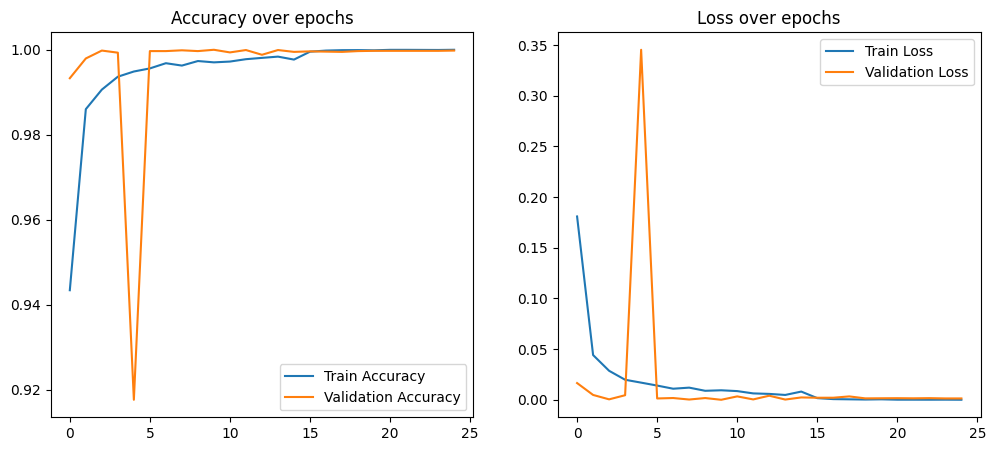

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train_res, y_train_res_encoded,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

Test Accuracy: 0.9861
Test AUC: 0.9982
Test Precision: 0.9861
Test Recall: 0.9861
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step

Classification Report:
                                   precision    recall  f1-score   support

                           Normal       0.99      0.99      0.99      2881
         Left Bundle Branch Block       1.00      1.00      1.00       499
        Right Bundle Branch Block       1.00      0.99      0.99       433
                 Atrial Premature       0.87      0.84      0.86       103
Premature Ventricular Contraction       0.96      0.97      0.96       286
 Fusion of Ventricular and Normal       0.07      0.33      0.11         3
                            Paced       1.00      1.00      1.00       406

                         accuracy                           0.99      4611
                        macro avg       0.84      0.87      0.84      4611
                     weighted avg       0.99      0.99      0.99      4611



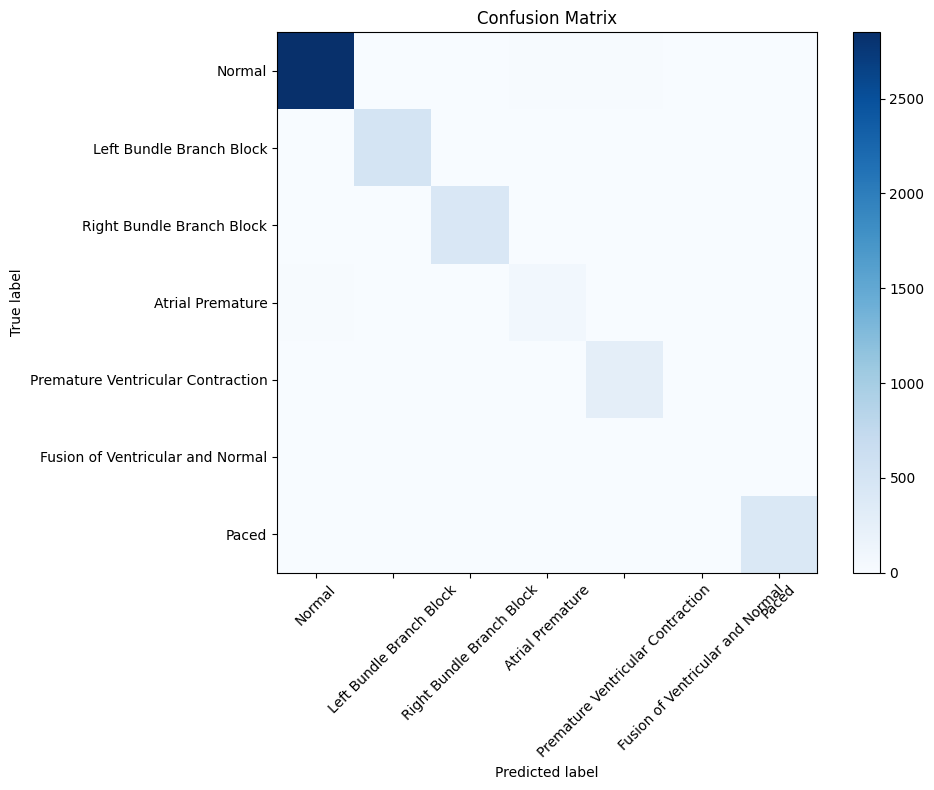

In [17]:
# Load best model
model = models.load_model('best_model.h5')

# Evaluate on test set
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=[detailed_classes[c] for c in selected_classes]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(selected_classes))
plt.xticks(tick_marks, [detailed_classes[c] for c in selected_classes], rotation=45)
plt.yticks(tick_marks, [detailed_classes[c] for c in selected_classes])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 280))
  warnings.warn(msg)


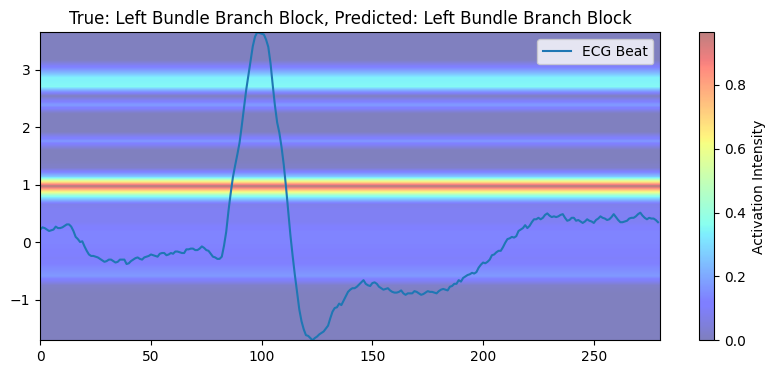

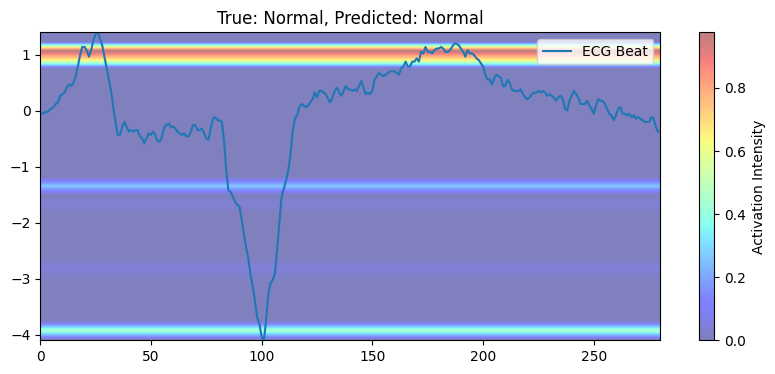

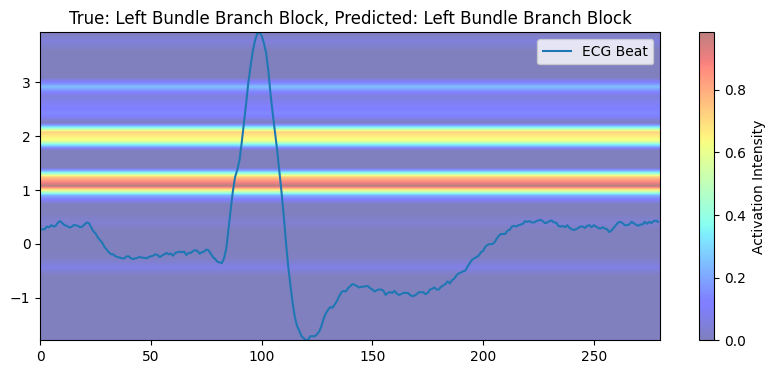

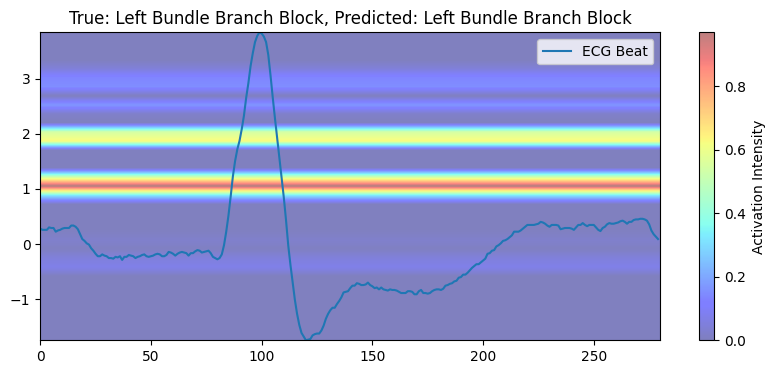

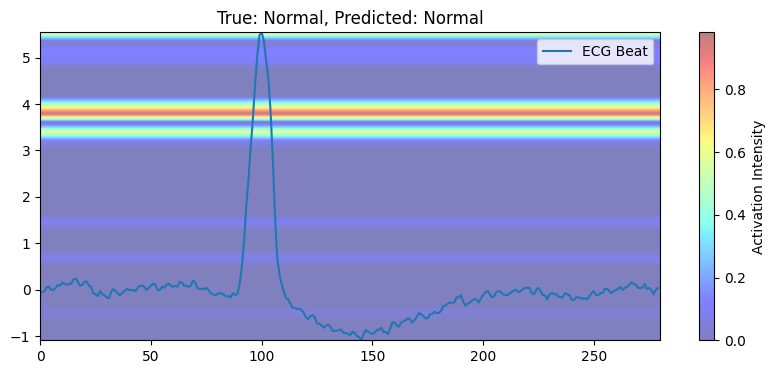

In [18]:
def plot_grad_cam(model, beat, label, layer_name='conv1d_3'):
    # Expand dimensions to match model input
    beat = np.expand_dims(beat, axis=0)

    # Get the last convolutional layer
    conv_layer = model.get_layer(layer_name)
    grad_model = models.Model(
        [model.inputs],
        [conv_layer.output, model.output]
    )

    # Compute gradient of top predicted class
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(beat)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of output neuron with respect to feature map
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Multiply each channel by gradient importance
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Resize heatmap to match original beat length
    heatmap = np.interp(np.linspace(0, len(heatmap)-1, len(beat.squeeze())),
                       np.arange(len(heatmap)), heatmap)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(beat.squeeze(), label='ECG Beat')
    plt.imshow(np.tile(heatmap, (20, 1)).T,
               aspect='auto',
               cmap='jet',
               alpha=0.5,
               extent=(0, len(beat.squeeze()), min(beat.squeeze()), max(beat.squeeze())))
    plt.title(f"True: {detailed_classes[selected_classes[label]]}, Predicted: {detailed_classes[selected_classes[pred_index]]}")
    plt.legend()
    plt.colorbar(label='Activation Intensity')
    plt.show()

# Plot Grad-CAM for some samples
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    plot_grad_cam(model, X_test[idx], y_test[idx])

In [19]:
# Save the model
model.save('ecg_arrhythmia_model.h5')

# Convert to TensorFlow Lite for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('ecg_arrhythmia_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save class labels
import json
with open('class_labels.json', 'w') as f:
    json.dump({i: detailed_classes[c] for i, c in enumerate(selected_classes)}, f)

Saved artifact at '/tmp/tmpe7anxdlv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 280, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132732736926736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736926544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736928272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736928848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736923280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736928464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736928656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736926160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736927696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132731056275280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132732736928080: Ten